# Hydroclimatic hazard - Irrigation filtration data processing
- Author: Eunkyoung Choi (kyoung.choi@colostate.edu)
- Version: June, 2021

In [1]:
## Import packages:
import numpy as np
import pandas as pd
import scipy.io
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

# 1) Option

In [3]:
'''
Please select which one to model:
crop_name = Maize, Soybeans, Spring Wheat, Sorghum
crop_yld_name = maize_yld, soy_yld, spr_wheat_yld, sorghum_yld

Note:
1. All data are from USDA NASS.
'''

crop_name = 'Maize'
crop_yld_name = 'maize_yld'


In [27]:
################################### Custom Functions #########################################################################
def usda_format(usda_crop,val_name, nass):
    usda_crop = usda_crop.rename(columns={'Value':val_name,'State ANSI':'state_id','County ANSI':'county_id','Year':'year'})
    usda_crop['state_id'] = usda_crop['state_id'].astype(str).str.zfill(2)
    usda_crop = usda_crop.loc[~usda_crop['County'].isin(['OTHER (COMBINED) COUNTIES','OTHER COUNTIES'])]
    usda_crop = usda_crop.loc[~usda_crop['county_id'].isnull()]
    usda_crop['county_id'] = usda_crop['county_id'].astype(int).astype(str).str.zfill(3)
    usda_crop['GEOID'] = usda_crop['state_id'] + usda_crop['county_id']
    if nass == 'Yield':
        usda_crop = usda_crop.loc[usda_crop['county_id'] != '998'].copy()
    elif nass == 'Harvested':    
        usda_crop.loc[usda_crop[val_name] == ' (D)', val_name] = np.nan
        usda_crop[val_name] = usda_crop[val_name].str.replace(',','').astype(float)
    return usda_crop[['State','state_id','county_id','GEOID','year',val_name,'Data Item']]


# 2) Total Grain Yield Data
- USDA NASS
- period: 1980-2020
- unit: bu/acre

In [5]:
################### opening yield data ######################################################################################
if crop_yld_name == 'maize_yld':
    usda1 = pd.read_csv('1_corn/1_survey_field_crop_total_yield_USDA/survey_field_crop_cron_total_yield_1981_2000_usda_8Mar2022_downloaded.csv', index_col=[0])
    usda2 = pd.read_csv('1_corn/1_survey_field_crop_total_yield_USDA/survey_field_crop_cron_total_yield_2001_2020_usda_8Mar2022_downloaded.csv', index_col=[0])
    usda1 = usda_format(usda1, crop_yld_name, 'Yield')
    usda2 = usda_format(usda2, crop_yld_name, 'Yield')
    usda_crop = pd.concat([usda1.reset_index(), usda2.reset_index()])
    del usda1, usda2
    data_path = '1_corn/1_survey_field_crop_total_yield_USDA/'
elif crop_yld_name == 'soy_yld':
    usda1 = pd.read_csv('2_soybeans/1_survey_field_crop_soybean_total_yields/survey_field_crop_soybeans_total_yield_1981_2000_8Mar2022_downloaded.csv', index_col=[0])
    usda2 = pd.read_csv('2_soybeans/1_survey_field_crop_soybean_total_yields/survey_field_crop_soybeans_total_yield_2001_2020_8Mar2022_downloaded.csv', index_col=[0])
    usda1 = usda_format(usda1, crop_yld_name, 'Yield')
    usda2 = usda_format(usda2, crop_yld_name, 'Yield')
    usda_crop = pd.concat([usda1.reset_index(), usda2.reset_index()])
    del usda1, usda2
    data_path = '2_soybean/1_survey_field_crop_soybean_total_yields/'
elif crop_yld_name == 'sorghum_yld':
    usda_crop = pd.read_csv('4_sorghum/1_survey_field_crop_sorghum_total_yields/survey_total_yield_sorghum_1981_2020_USDA.csv', index_col=[0])
    usda_crop = usda_format(usda_crop, crop_yld_name, 'Yield')
    data_path = '4_sorghum/1_survey_field_crop_sorghum_total_yields/'
elif crop_yld_name == 'spr_wheat_yld':
    usda_crop = pd.read_csv('3_spring_wheat/1_survey_field_crop_spring_wheat_total_yields/survey_total_yield_spring_wheat_1981_2020_USDA_raw.csv', index_col=[0])
    usda_crop = usda_format(usda_crop, crop_yld_name, 'Yield')
    data_path = '3_spring_wheat/1_survey_field_crop_spring_wheat_total_yields/
    
print(usda_crop['Data Item'].unique())

['CORN, GRAIN - YIELD, MEASURED IN BU / ACRE']


In [7]:
## check if there are any zero values or nan values for yields:
print(usda_crop.loc[(usda_crop[crop_yld_name] == 0)].shape)
usda_crop.loc[(usda_crop[crop_yld_name].isnull())].shape

(501, 8)


(0, 8)

In [14]:
### saving yield data:
usda_crop_df.to_csv(data_path+'survey_total_yield_'+crop_yld_name+'_1981_2020_USDA_final_3June2022.csv')

# 3) Irrigated county - harvested area data:
- total_harvest & irrigated harvest area from Census
- period: 1997, 2002, 2007, 2012, 2017 (Census data only available for 5 years as of 2021)
- unit: acres harvested


## 3-1) total harvested area (irri+rainfed)

In [28]:
################### opening yield data ######################################################################################

if crop_yld_name == 'maize_yld':
    data_path = '1_corn/2_census_field_crop_harvested_acrea_USDA/'
    tot_harvest = pd.read_csv(data_path+'/census_5years_field_crop_corn_total_harvested_acres_8Mar2022_download.csv', index_col=[0])
elif crop_yld_name == 'soy_yld':
    data_path = '2_soybean/2_cencus_field_crop_soybean_acres/'
    tot_harvest = pd.read_csv(data_path+'/census_5years_field_crop_soybeans_total_harvested_acres_8Mar2022_download.csv', index_col=[0])
elif crop_yld_name == 'sorghum_yld':
    data_path = '4_sorghum/2_census_field_crop_sorghum_acres/'
    tot_harvest = pd.read_csv(data_path+'/census_5years_field_crop_sorghum_total_harvested_acreas_17Feb2022_downloaded.csv', index_col=[0])
elif crop_yld_name == 'spr_wheat_yld':
    data_path = '3_spring_wheat/2_census_field_crop_spring_wheat_acres/'
    tot_harvest = pd.read_csv(data_path+'/census_5years_field_crop_spring_wheat_total_harvested_acres_17Feb2022_downloaded.csv', index_col=[0])

tot_harvest = usda_format(tot_harvest, 'tot_harvest', 'Harvested')
print(tot_harvest['Data Item'].unique())   

['CORN, GRAIN - ACRES HARVESTED']


In [29]:
## check if there are any zero values or nan values for harvested areas:
print(tot_harvest.loc[tot_harvest['tot_harvest'] ==0].shape,
    tot_harvest.loc[tot_harvest['tot_harvest'].isnull()].groupby(['GEOID','year'])['tot_harvest'].count().shape)
tot_harvest.loc[tot_harvest['tot_harvest'].isnull()]

(0, 7) (1277,)


,State,state_id,county_id,GEOID,year,tot_harvest,Data Item
Program,,,,,,,
CENSUS,ALABAMA,01,065,01065,2017,NaN,"CORN, GRAIN - ACRES HARVESTED"
CENSUS,ALABAMA,01,087,01087,2017,NaN,"CORN, GRAIN - ACRES HARVESTED"
CENSUS,ALABAMA,01,023,01023,2017,NaN,"CORN, GRAIN - ACRES HARVESTED"
CENSUS,ALABAMA,01,097,01097,2017,NaN,"CORN, GRAIN - ACRES HARVESTED"
CENSUS,ALABAMA,01,027,01027,2017,NaN,"CORN, GRAIN - ACRES HARVESTED"
...,...,...,...,...,...,...,...
CENSUS,VIRGINIA,51,199,51199,1997,NaN,"CORN, GRAIN - ACRES HARVESTED"
CENSUS,VIRGINIA,51,005,51005,1997,NaN,"CORN, GRAIN - ACRES HARVESTED"
CENSUS,WASHINGTON,53,005,53005,1997,NaN,"CORN, GRAIN - ACRES HARVESTED"


      GEOID
year       
1       184
2       133
3       112
4       152
5      2047


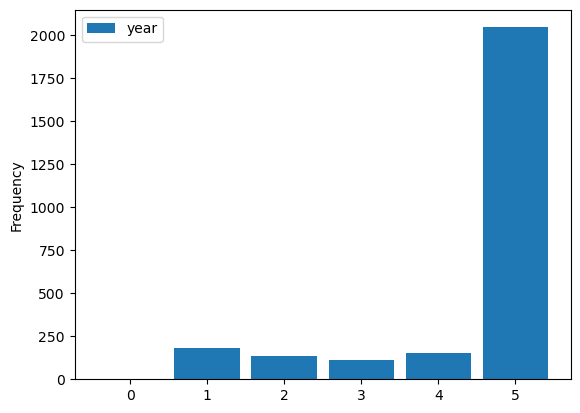

In [30]:
## visual plot of counties for how many years of harvest data they have:
tot_harvest.dropna(subset=['tot_harvest'])[['GEOID','year']].drop_duplicates().groupby('GEOID').count().plot.hist(bins=np.arange(0,7,1), rwidth=0.85, align='left')
print(tot_harvest.dropna(subset=['tot_harvest'])[['GEOID','year']].drop_duplicates().groupby('GEOID').count().reset_index().groupby('year').count())


## 3-2) irrigated harvest area data

In [31]:
if crop_yld_name == 'maize_yld':
    data_path = '1_corn/2_census_field_crop_harvested_acrea_USDA'
    irri_harvest = pd.read_csv(data_path+'/census_5years_field_crop_corn_irrigated_harvested_acres_8Mar2022_download.csv', index_col=[0])
elif crop_yld_name == 'soy_yld':
    data_path = '2_soybean/2_cencus_field_crop_soybean_acres'
    irri_harvest = pd.read_csv(data_path+'/census_5years_field_crop_soybeans_irrigated_harvested_acres_8Mar2022_download.csv', index_col=[0])
elif crop_yld_name == 'sorghum_yld':
    data_path = '4_sorghum/2_census_field_crop_sorghum_acres'
    irri_harvest = pd.read_csv(data_path+'/census_5years_field_crop_sorghum_irrigated_harvested_acreas_17Feb2022_downloaded.csv', index_col=[0])
elif crop_yld_name == 'spr_wheat_yld':
    data_path = '3_spring_wheat/2_census_field_crop_spring_wheat_acres/'
    irri_harvest = pd.read_csv(data_path+'/census_5years_field_crop_spring_wheat_irrigated_harvested_acres_17Feb2022_downloaded.csv', index_col=[0])

irri_harvest = usda_format(irri_harvest, 'irri_harvest', 'Harvested')
print(irri_harvest['Data Item'].unique()) 

['CORN, GRAIN, IRRIGATED - ACRES HARVESTED']


(8212,) (3233,)
      GEOID
year       
1       388
2       185
3       108
4       183
5       633


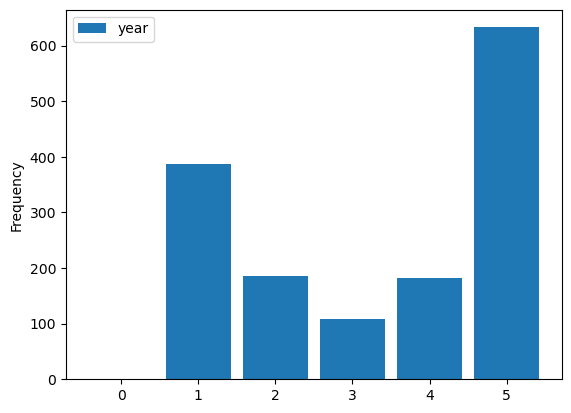

In [33]:
print(irri_harvest.groupby(['GEOID','year'])['irri_harvest'].count().shape,
     irri_harvest.loc[irri_harvest['irri_harvest'].isnull()].groupby(['GEOID','year'])['irri_harvest'].count().shape)
irri_harvest.dropna(subset=['irri_harvest'])[['GEOID','year']].drop_duplicates().groupby(['GEOID']).count().plot.hist(bins=np.arange(0,7,1), rwidth=0.85, align='left')
print(irri_harvest.dropna(subset=['irri_harvest'])[['GEOID','year']].drop_duplicates().groupby('GEOID').count().reset_index().groupby('year').count())

## 3-3) Merging 
- Merging total harvest and irrigated harvest data into one dataframe

In [34]:
harvest_temp = pd.merge(tot_harvest.drop('Data Item',axis=1).dropna(subset=['tot_harvest']),
                        irri_harvest[['state_id','county_id','GEOID','year','irri_harvest']].dropna(subset=['irri_harvest']), 
                        on=['state_id','county_id','GEOID','year'], how='outer',indicator=True)
print('tot_harvest + irri_harvest merge?',harvest_temp._merge.unique())
print('tot_harshape:', tot_harvest.shape, 'irri_har shape:', irri_harvest.shape,
      'merged shape:',harvest_temp.shape)
# 35037 35023 counties are both included in "both" and "left_only", that's why total GEOID for both is 1493 rather than 1491:
print('tot_har',tot_harvest.dropna(subset=['tot_harvest']).groupby(['GEOID','year'])['tot_harvest'].count().shape,
      'irri',irri_harvest.dropna(subset=['irri_harvest']).groupby(['GEOID','year'])['irri_harvest'].count().shape,
      'both:',harvest_temp.loc[harvest_temp['_merge']=='both'].groupby(['GEOID','year'])['tot_harvest'].count().shape)
harvest_temp = harvest_temp.rename(columns={'_merge':'tot+irri_har_merge'})
print(harvest_temp['tot+irri_har_merge'].unique())

tot_harvest + irri_harvest merge? ['left_only', 'both', 'right_only']
Categories (3, object): ['left_only', 'right_only', 'both']
tot_harshape: (12906, 7) irri_har shape: (8212, 7) merged shape: (11635, 8)
tot_har (11629,) irri (4979,) both: (4973,)
['left_only', 'both', 'right_only']
Categories (3, object): ['left_only', 'right_only', 'both']


In [25]:
### saving file:
harvest.to_csv(data_path+'census_'+crop_yld_name+'_combined_total_irrigated_harvest_counties_3June2022.csv')